In [2]:
pip install thefuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from thefuzz import fuzz
from thefuzz import process
import re
import difflib
import seaborn as sns
import matplotlib.pyplot as plt

## Import Data

In [4]:
abilities = pd.read_excel("Abilities.xlsx")

In [5]:
skills = pd.read_excel("Skills.xlsx")

In [6]:
ai_risk = pd.read_csv("My_Data.csv")

## Review the Data

In [7]:
abilities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90792 entries, 0 to 90791
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   O*NET-SOC Code      90792 non-null  object 
 1   Title               90792 non-null  object 
 2   Element ID          90792 non-null  object 
 3   Element Name        90792 non-null  object 
 4   Scale ID            90792 non-null  object 
 5   Scale Name          90792 non-null  object 
 6   Data Value          90792 non-null  float64
 7   N                   88608 non-null  float64
 8   Standard Error      88608 non-null  float64
 9   Lower CI Bound      88608 non-null  float64
 10  Upper CI Bound      88608 non-null  float64
 11  Recommend Suppress  90792 non-null  object 
 12  Not Relevant        45396 non-null  object 
 13  Date                90792 non-null  object 
 14  Domain Source       90792 non-null  object 
dtypes: float64(5), object(10)
memory usage: 10.4+ MB


In [8]:
skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61110 entries, 0 to 61109
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   O*NET-SOC Code      61110 non-null  object 
 1   Title               61110 non-null  object 
 2   Element ID          61110 non-null  object 
 3   Element Name        61110 non-null  object 
 4   Scale ID            61110 non-null  object 
 5   Scale Name          61110 non-null  object 
 6   Data Value          61110 non-null  float64
 7   N                   59640 non-null  float64
 8   Standard Error      59640 non-null  float64
 9   Lower CI Bound      59640 non-null  float64
 10  Upper CI Bound      59640 non-null  float64
 11  Recommend Suppress  61110 non-null  object 
 12  Not Relevant        30555 non-null  object 
 13  Date                61110 non-null  object 
 14  Domain Source       61110 non-null  object 
dtypes: float64(5), object(10)
memory usage: 7.0+ MB


In [9]:
ai_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4706 entries, 0 to 4705
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job titiles        4706 non-null   object 
 1   AI Impact          4706 non-null   object 
 2   Tasks              4706 non-null   int64  
 3   AI models          4706 non-null   int64  
 4   AI_Workload_Ratio  4706 non-null   float64
 5   Domain             4706 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 220.7+ KB


### Reconfigure the dataset to be a crosstab

In [10]:
abilities_importance = abilities[abilities["Scale Name"] == "Importance"]

In [12]:
abilities_level = abilities[abilities["Scale Name"] == "Level"]

In [11]:
skills_importance = skills[skills["Scale Name"] == "Importance"]

In [13]:
skills_level = skills[skills["Scale Name"] == "Level"]

Count how many entries (abilities and skills) there are per title in the dataset

In [14]:
## Sample title for analysis - ABILITIES
abilities_importance.loc[abilities_importance["Title"] == "Chief Executives", "Element Name"].count()

52

In [15]:
## Sample title for analysis - SKILLS

skills_importance.loc[skills_importance["Title"] == "Chief Executives", "Element Name"].count()

35

In [17]:
## Shorten the datasets for easier use
abilities_importance.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"], inplace = True)
abilities_level.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"], inplace = True)
skills_importance.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"], inplace = True)
skills_level.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"], inplace = True)

<ipython-input-17-318d0258963a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abilities_importance.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
<ipython-input-17-318d0258963a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abilities_level.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
<ipython-input-17-318d0258963a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skills_import

Create an SOC-Title Index for future use

In [77]:
SOC_codes = abilities.groupby("O*NET-SOC Code")["Title"].apply(np.unique)

In [79]:
SOC_codes_df = pd.DataFrame(SOC_codes)

In [80]:
SOC_codes_df["Adj_Title"] = SOC_codes_df.Title.apply(lambda x: ''.join([str(i) for i in x]))

In [81]:
SOC_codes_df.reset_index(inplace=True)

Create a cross tab with Titles and SOC codes

In [46]:
abilities_importance_crosstab = pd.crosstab(abilities_importance["Title"], abilities_importance["Element Name"],
                                            values=abilities_importance["Data Value"], aggfunc='mean').round(1)

In [47]:
abilities_importance_crosstab.reset_index(inplace=True)

In [82]:
abilities_importance_crosstab = abilities_importance_crosstab.merge(SOC_codes_df['O*NET-SOC Code'], left_on=['Title'], right_on=SOC_codes_df["Adj_Title"], how='inner')

In [84]:
abilities_importance_crosstab.drop(columns = ["Adj_Title"], inplace=True)

In [88]:
abilities_level_crosstab = pd.crosstab(abilities_level["Title"], abilities_level["Element Name"],
                                            values=abilities_level["Data Value"], aggfunc='mean').round(1)

In [90]:
abilities_level_crosstab.reset_index(inplace=True)

In [86]:
skills_importance_crosstab = pd.crosstab(skills_importance["Title"], skills_importance["Element Name"],
                                values=skills_importance["Data Value"], aggfunc='mean').round(1)

In [95]:
skills_importance_crosstab.reset_index(inplace=True)

In [87]:
skills_level_crosstab = pd.crosstab(skills_level["Title"], skills_level["Element Name"],
                                values=skills_level["Data Value"], aggfunc='mean').round(1)

In [ ]:
skills_level_crosstab.reset_index(inplace=True)

Combine level and importance for Abilities and Skills

In [135]:
full_dataset_occupations = abilities_importance_crosstab.merge(abilities_level_crosstab,
                                                               left_on=["Title"], right_on=["Title"], how="inner",
                                                               suffixes = ["_importance", "_level"])

In [136]:
full_dataset_occupations = full_dataset_occupations.merge(skills_importance_crosstab,
                                                          left_on=["Title"], right_on=["Title"], how="inner",
                                                          suffixes = ["_importance", "_level"])

In [100]:
skills_merge = skills_importance_crosstab.merge(skills_level_crosstab,
                                                left_on=["Title"], right_on=["Title"], how="inner",
                                                suffixes = ["_importance", "_level"])

In [137]:
full_dataset_occupations = full_dataset_occupations.merge(skills_merge,
                                                          left_on=["Title"], right_on=["Title"], how="inner")

In [111]:
full_dataset_occupations.describe()

,Arm-Hand Steadiness_importance,Auditory Attention_importance,Category Flexibility_importance,Control Precision_importance,Deductive Reasoning_importance,Depth Perception_importance,Dynamic Flexibility_importance,Dynamic Strength_importance,Explosive Strength_importance,Extent Flexibility_importance,...,Science_level,Service Orientation_level,Social Perceptiveness_level,Speaking_level,Systems Analysis_level,Systems Evaluation_level,Technology Design_level,Time Management_level,Troubleshooting_level,Writing_level
count,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,...,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000
mean,2.569530,2.382703,3.133448,2.419015,3.499427,2.165636,1.131271,1.824628,1.423139,2.015006,...,1.474112,2.852806,3.108362,3.468958,2.643872,2.634593,1.013746,3.046048,1.569072,3.303780
std,0.900414,0.447020,0.334663,0.888938,0.454273,0.611781,0.263438,0.624647,0.445483,0.816525,...,1.407799,0.627445,0.670862,0.721070,0.821884,0.858788,0.725387,0.501018,1.145156,0.850834
min,1.000000,1.100000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.900000,1.800000,1.900000,0.000000,0.100000,0.000000,1.600000,0.000000,1.000000
25%,1.900000,2.000000,3.000000,1.800000,3.100000,1.800000,1.000000,1.200000,1.000000,1.100000,...,0.200000,2.400000,2.600000,2.900000,2.000000,2.000000,0.600000,2.800000,0.500000,2.800000
50%,2.800000,2.200000,3.100000,2.400000,3.500000,2.100000,1.000000,1.900000,1.400000,2.000000,...,1.000000,2.900000,3.000000,3.600000,2.800000,2.800000,0.900000,3.000000,1.600000,3.200000
75%,3.200000,2.800000,3.200000,3.100000,3.900000,2.600000,1.100000,2.200000,1.800000,2.800000,...,2.600000,3.100000,3.600000,4.000000,3.100000,3.200000,1.200000,3.400000,2.500000,4.000000
max,4.200000,3.900000,4.000000,4.600000,4.600000,4.100000,3.600000,4.200000,3.600000,4.500000,...,5.800000,5.200000,5.800000,5.000000,5.100000,5.000000,4.100000,4.800000,4.000000,5.800000


In [114]:
ai_risk.rename(columns = {
    "Job titiles" : "Job_title"
}, inplace = True)

In [125]:
basic_lookup_in_risk_index = ai_risk[ai_risk['Job_title'].str.contains('PR')]
basic_lookup_in_risk_index

,Job_title,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain
626,CPR Instructor,50%,64,489,0.130879,Law Enforcement


In [129]:
basic_lookup_in_occupations_index = full_dataset_occupations[full_dataset_occupations["Title"].str.contains("Welder")]
basic_lookup_in_occupations_index

,Title,Arm-Hand Steadiness_importance,Auditory Attention_importance,Category Flexibility_importance,Control Precision_importance,Deductive Reasoning_importance,Depth Perception_importance,Dynamic Flexibility_importance,Dynamic Strength_importance,Explosive Strength_importance,...,Science_level,Service Orientation_level,Social Perceptiveness_level,Speaking_level,Systems Analysis_level,Systems Evaluation_level,Technology Design_level,Time Management_level,Troubleshooting_level,Writing_level
861,"Welders, Cutters, Solderers, and Brazers",3.6,2.6,2.9,3.1,3.0,2.8,1.6,2.1,2.1,...,1.0,1.5,2.1,2.0,1.8,1.5,0.8,2.2,2.1,1.5


##Clean up job titles in Occupations Dataset

In [180]:
full_dataset_occupations_copy = full_dataset_occupations.copy()

In [181]:
full_dataset_occupations_copy = [re.split(r',|, and', x) for x in full_dataset_occupations_copy["Title"]]

In [183]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if x[y][-1] == "s":
      x[y] = x[y].rstrip(x[y][-1])

In [184]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if x[y][-2:] == "ie":
      x[y] = re.sub(r'.{2}$',"y",x[y])

In [185]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
      x[y] = x[y].replace('s and',"")

In [186]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if x[y][0:5] == " and ":
      x[y] = re.sub(r'^.{0,5}', "", x[y])

In [187]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if x[y][0] == " ":
      x[y] = x[y].strip()

In [188]:
exceptions = []
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if "except" in x[y]:
      m = y
      for y in range(m,len(x)+1):
        exceptions.append(x[y])

In [193]:
full_dataset_occupations_copy_titles = pd.DataFrame(full_dataset_occupations_copy, columns=['Title1','Title2','Title3',
                                            'Title4','Title5','Title6','Title7'])

In [194]:
full_dataset_occupations_copy_titles = full_dataset_occupations_copy_titles.merge(full_dataset_occupations["Title"],
                                                          left_index = True, right_index = True, how="inner")

In [196]:
full_dataset_occupations_copy_titles = full_dataset_occupations_copy_titles.merge(SOC_codes_df["O*NET-SOC Code"],
                                                                                  left_on=full_dataset_occupations_copy_titles["Title"], right_on=SOC_codes_df["Adj_Title"], how="inner")

In [198]:
full_dataset_occupations_copy_titles.drop(columns = ["key_0"], inplace=True)

In [200]:
full_dataset_occupations_copy_titles.isna().sum()

Title1              0
Title2            639
Title3            760
Title4            824
Title5            860
Title6            868
Title7            871
Title               0
O*NET-SOC Code      0
dtype: int64

In [201]:
full_dataset_occupations_copy_titles.to_csv('Job_Titles_US_Census.csv')

##Analyzing our dataset
Matching titles across datasets

In [42]:
df.fillna("", inplace=True)

In [71]:
df["Titles_joined"] = df[['Title1', 'Title2','Title3',
                          'Title4','Title5','Title6','Title7']].apply(lambda x: '-'.join(x), axis=1)

In [72]:
df["Titles_joined_match"] = df["Titles_joined"]

In [82]:
df["Titles_joined_match"] = df["Titles_joined_match"].apply(lambda x: '-'.join(x))

In [76]:
df["Titles_joined_match"] = df["Titles_joined"].apply(lambda x: difflib.get_close_matches(x, job_threat_index["Job titiles"]))


In [90]:
df["Titles_joined"] = df["Titles_joined"].apply(lambda x: x.replace("--",""))

In [92]:
df["Titles_joined_match_ratio"] = df.apply(lambda x: fuzz.ratio(x.Titles_joined_match, x.Titles_joined), axis=1)

#fuzz.ratio(job_threat_index["Titles_match"],job_threat_index["Job titiles"])

In [102]:
df[["Titles_joined_match", "Titles_joined","Titles_joined_match_ratio"]].sort_values(by=['Titles_joined_match_ratio'], ascending=False)

,Titles_joined_match,Titles_joined,Titles_joined_match_ratio
796,Surveyor,Surveyor,100
69,Barber,Barber,100
594,Orderly,Orderly,100
239,Editor,Editor,100
356,Fundraiser,Fundraiser,100
...,...,...,...
622,,Petroleum Pump System Operator-Refinery Operat...,0
328,,First-Line Supervisors of Retail Sales Worker,0
620,,Pesticide Handler-Sprayer-Applicator-Vegetation-,0
329,,Fish and Game Warden,0


In [98]:
job_threat_index.rename(columns = {"Job titiles": "Job_titles"}, inplace=True)

In [50]:
job_threat_index["Titles_match"] = job_threat_index["Job_titles"]

In [95]:
job_threat_index["Titles_match"] = job_threat_index["Titles_match"].apply(lambda x: '-'.join(x))

In [96]:
job_threat_index["Titles_match"] = job_threat_index["Titles_match"].apply(lambda x: x.replace("--",""))

In [51]:
job_threat_index["Titles_match"] = job_threat_index["Job_titles"].apply(lambda x: difflib.get_close_matches(x, df["Titles_joined"]))


In [99]:
job_threat_index["Similarity%"] =  job_threat_index.apply(lambda x: fuzz.ratio(x.Titles_match, x.Job_titles), axis=1)
#fuzz.ratio(job_threat_index["Titles_match"],job_threat_index["Job titiles"])

In [167]:
job_threat_index[["Job_titles", "Titles_match", "Similarity%"]].sort_values(by=['Similarity%'], ascending=False)

,Job_titles,Titles_match,Similarity%
2957,Geneticist,Geneticist,100
4137,Desktop Publisher,Desktop Publisher,100
1729,Administrative Services Manager,Administrative Services Manager,100
1734,Management Analyst,Management Analyst,100
2577,Boilermaker,Boilermaker,100
4224,Firefighter,Firefighter,100
3314,Embalmer,Embalmer,100
3319,Personal Care Aide,Personal Care Aide,100
194,Cashier,Cashier,100
197,Actuary,Actuary,100


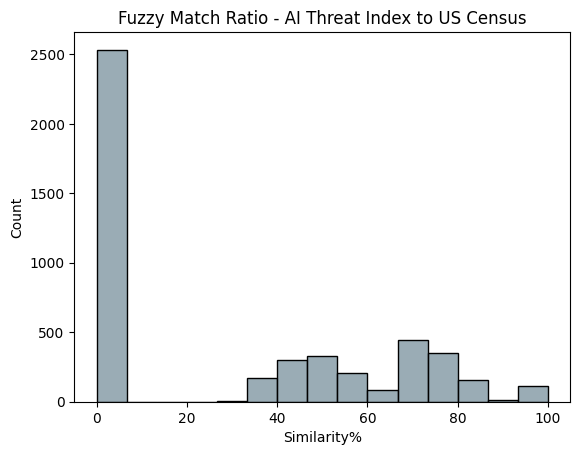

In [108]:
fig = plt.plot(figsize=(8, 8))

sns.histplot(data=job_threat_index, x=job_threat_index["Similarity%"], color='#78909c').set(title='Fuzzy Match Ratio - AI Threat Index to US Census');


In [114]:
mean_similarity = np.mean(job_threat_index["Similarity%"])
mean_similarity

28.88652783680408

In [118]:
filtered_job_threat_index = job_threat_index[job_threat_index["Similarity%"] <= 50]
filtered_job_threat_index

,Job_titles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain,Titles_match,Similarity%
1,Data Collector,95%,299,2148,0.139199,Data & IT,,0
6,Therapist,90%,114,983,0.115972,Law Enforcement,Art Therapist-Music Therapist,47
8,Admin,90%,253,2014,0.125621,Sales & Marketing,,0
9,General Clerk,90%,242,1903,0.127168,Hospitality,,0
10,Mail Handler,90%,188,1350,0.139259,Communication & PR,,0
...,...,...,...,...,...,...,...,...
4700,Pianist,5%,586,2410,0.243154,Communication & PR,,0
4701,Singer,5%,686,2798,0.245175,Data & IT,,0
4702,Airport,5%,556,2206,0.252040,Administrative & Clerical,,0
4704,Nurse,5%,710,2594,0.273709,Medical & Healthcare,,0


In [136]:
titlesjoin="|".join(df["Titles_joined"])
titlesjoin

"Accountant Auditor|Actor|Actuary|Acupuncturist|Acute Care Nurse|Adapted Physical Education Specialist|Adhesive Bonding Machine Operator Tender|Administrative Law Judge-Adjudicator-Hearing Officer|Administrative Services Manager|Adult Basic Education-Adult Secondary Education-English as a Second Language Instructor|Advanced Practice Psychiatric Nurse|Advertising Sales Agent|Advertising and Promotions Manager|Aerospace Engineering and Operations Technologist Technician|Aerospace Engineer|Agent Business Managers of Artist-Performer-Athlete|Agricultural Engineer|Agricultural Equipment Operator|Agricultural Inspector|Agricultural Sciences Teacher-Postsecondary-|Agricultural Technician|Air Traffic Controller|Aircraft Cargo Handling Supervisor|Aircraft Mechanic Service Technician|Aircraft Structure-Surface-Rigging-Systems Assembler-|Airfield Operations Specialist|Airline Pilot-Copilot-Flight Engineer|Allergist Immunologist|Ambulance Driver Attendant-Except Emergency Medical Technician-|Amuse

In [140]:
#job_threat_index = job_threat_index.assign(Match = job_threat_index["Job_titles"].str.findall(titlesjoin))
test = job_threat_index[job_threat_index["Job_titles"].str.contains(titlesjoin)]
test

,Job_titles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain,Titles_match,Similarity%,Match
4,Compliance Officer,92%,194,1369,0.141709,Medical & Healthcare,Compliance Officer-Compliance Manager-Loan Off...,53,[Compliance Officer]
5,Chief Executive Officer (CEO),91%,153,1135,0.134802,Supply Chain & Logistics,Chief Executive,68,[Chief Executive]
15,Medical Transcriptionist,90%,189,1265,0.149407,Supply Chain & Logistics,Medical Transcriptionist,100,[Medical Transcriptionist]
23,File Clerk,88%,228,1797,0.126878,Leadership & Strategy,File Clerk,100,[File Clerk]
38,Telemarketer,85%,179,1281,0.139735,Sales & Marketing,Telemarketer,100,[Telemarketer]
...,...,...,...,...,...,...,...,...,...
4662,Spa Manager,5%,420,2080,0.201923,Administrative & Clerical,Spa Manager-Sales Manager-Range Manager,44,[Spa Manager]
4664,Geographer,5%,631,2548,0.247645,Medical & Healthcare,Geographer-Choreographer,59,[Geographer]
4666,Historian,5%,684,2672,0.255988,Law Enforcement,Historian,100,[Historian]
4668,Head Teller,5%,675,2448,0.275735,Sales & Marketing,,0,[Teller]


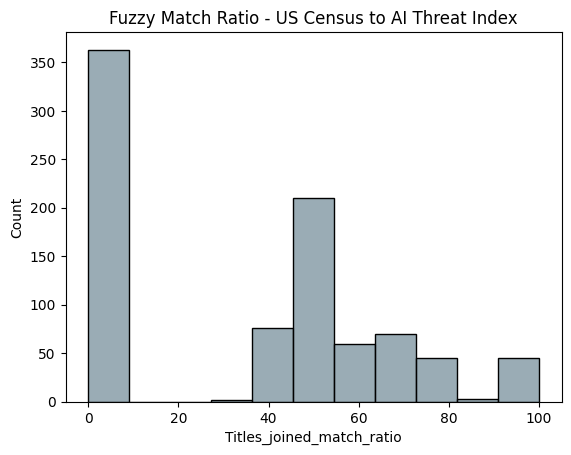

In [109]:
fig = plt.plot(figsize=(8, 8))

sns.histplot(data=df, x=df["Titles_joined_match_ratio"], color='#78909c').set(title='Fuzzy Match Ratio - US Census to AI Threat Index');


In [115]:
mean_similarity_ = np.mean(df["Titles_joined_match_ratio"])
mean_similarity_

34.49026345933562

In [119]:
filtered_census = df[df["Titles_joined_match_ratio"] <= 50]
filtered_census

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Titles_joined,Titles_joined_match,Titles_joined_match_ratio
0,Accountant Auditor,,,,,,,Accountant Auditor,Accounting Auditor-Accounting Administrator-Ac...,41
5,Adapted Physical Education Specialist,,,,,,,Adapted Physical Education Specialist,Education Specialist-Medical Information Speci...,49
9,Adult Basic Education,Adult Secondary Education,English as a Second Language Instructor,,,,,Adult Basic Education-Adult Secondary Educatio...,,0
10,Advanced Practice Psychiatric Nurse,,,,,,,Advanced Practice Psychiatric Nurse,,0
11,Advertising Sales Agent,,,,,,,Advertising Sales Agent,Advertising Sales-Advertising Sales Representa...,47
...,...,...,...,...,...,...,...,...,...,...
865,Wind Energy Development Manager,,,,,,,Wind Energy Development Manager,Business Development Manager-Development Manag...,48
866,Wind Energy Engineer,,,,,,,Wind Energy Engineer,Energy Engineer-Mining Engineer-Welding Engineer,50
867,Wind Energy Operations Manager,,,,,,,Wind Energy Operations Manager,Business Operations Manager-Senior Operations ...,46
869,Woodworking Machine Setter,Operator,Tender,Except Sawing,,,,Woodworking Machine Setter-Operator-Tender-Exc...,,0


In [141]:
titlesjoin_="|".join(job_threat_index["Job_titles"])
titlesjoin_

'Communications Manager|Data Collector|Data Entry|Mail Clerk|Compliance Officer|Chief Executive Officer (CEO)|Therapist|Chief Strategy Officer|Admin|General Clerk|Mail Handler|Data Clerk|Data Entry Clerk|Data Entry Operator|Data Entry Specialist|Medical Transcriptionist|Street Sweeper|Supply Clerk|Warehouse Worker|Web Search Evaluator|Development Manager|Delivery Driver|Chief Security Officer|File Clerk|Mail Processing|Director Of Operations|Direct Support Professional|Chief Communications Officer|Administrative Clerk|Executive Assistant|General Office Clerk|Transcriber|Sql Programmer|Vba Developer|Medical Scribe|Special Agent|Purchasing Clerk|Bricklayer|Telemarketer|Bakery Manager|Banquet Manager|Clerk Typist|Assistant|Business Relationship Manager|Distribution Manager|Administrative Assistant|Administrative Secretary|Clerical Assistant|Executive Administrative Assistant|Order Filler|Records Clerk|Scribe|Typist|Dishwasher|Digital Project Manager|Technical Project Manager|Grocer|Financ

In [159]:
df = df.assign(Match = df["Title1"].str.findall(titlesjoin_))

In [160]:
test_ = df

In [161]:
test_ = test_[test_["Title1"].str.match(titlesjoin_)]
test_

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Titles_joined,Titles_joined_match,Titles_joined_match_ratio,Match
0,Accountant Auditor,,,,,,,Accountant Auditor,Accounting Auditor-Accounting Administrator-Ac...,41,"[(, ), (, )]"
1,Actor,,,,,,,Actor,Actor,100,"[(, )]"
2,Actuary,,,,,,,Actuary,Actuary,100,"[(, )]"
3,Acupuncturist,,,,,,,Acupuncturist,Acupuncturist,100,"[(, )]"
7,Administrative Law Judge,Adjudicator,Hearing Officer,,,,,Administrative Law Judge-Adjudicator-Hearing O...,Administrative Law Judge,63,"[(, ), (, )]"
...,...,...,...,...,...,...,...,...,...,...,...
861,Welder,Cutter,Solderer,Brazer,,,,Welder-Cutter-Solderer-Brazer-,,0,"[(, )]"
862,Welding,Soldering,Brazing Machine Setter,Operator,Tender,,,Welding-Soldering-Brazing Machine Setter-Opera...,,0,"[(, )]"
870,Word Processor Typist,,,,,,,Word Processor Typist,Word Processor,80,"[(, ), (, )]"
871,Writer Author,,,,,,,Writer Author,,0,"[(, ), (, )]"


In [163]:
pd.set_option('display.max_rows', None)

In [166]:
filtered_census[["Title1", "Titles_joined", "Titles_joined_match", "Titles_joined_match_ratio"]]

,Title1,Titles_joined,Titles_joined_match,Titles_joined_match_ratio
0,Accountant Auditor,Accountant Auditor,Accounting Auditor-Accounting Administrator-Ac...,41
5,Adapted Physical Education Specialist,Adapted Physical Education Specialist,Education Specialist-Medical Information Speci...,49
9,Adult Basic Education,Adult Basic Education-Adult Secondary Educatio...,,0
10,Advanced Practice Psychiatric Nurse,Advanced Practice Psychiatric Nurse,,0
11,Advertising Sales Agent,Advertising Sales Agent,Advertising Sales-Advertising Sales Representa...,47
13,Aerospace Engineering and Operations Technolog...,Aerospace Engineering and Operations Technolog...,,0
14,Aerospace Engineer,Aerospace Engineer,Aerospace Engineer-Performance Engineer-Aerona...,46
15,Agent Business Managers of Artist,Agent Business Managers of Artist-Performer-At...,,0
16,Agricultural Engineer,Agricultural Engineer,Agricultural Engineer-Structural Engineer-Arch...,49
17,Agricultural Equipment Operator,Agricultural Equipment Operator,Heavy Equipment Operator-Equipment Operator-He...,48


In [ ]:
reps = [2 if val=="b" else 1 for val in df.col1]
df.loc[np.repeat(df.index.values, reps)]

Split on "," and "and":
1. Split occupation titles on ", and " and ", "
2. Replace "ie" at the end of occupations with "y"
3. Strip "s" at the end of occupations (problems with certain fields like "gas" and "waitresses")
4. Trim leading spaces
5. Remove all words following "except"